In [2]:
# Complete 3D-GCN DILIrank Classification Model
# 통합된 전체 코드 - 바로 실행 가능

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, TopKPooling
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_fscore_support, 
                           balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import warnings
from pathlib import Path
import json
warnings.filterwarnings('ignore')


In [2]:
# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 가능한 디바이스: {device}")

# 시드 고정
torch.manual_seed(42)
np.random.seed(42)

사용 가능한 디바이스: cuda


In [7]:
# 1. 데이터 캐싱 시스템
# ============================================================================

class DataCache:
    """그래프 데이터 캐싱을 위한 클래스"""
    
    def __init__(self, cache_dir="./cache"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        
    def get_cache_path(self, filename):
        return self.cache_dir / f"{filename}.pkl"
    
    def save_data(self, data, filename):
        cache_path = self.get_cache_path(filename)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"데이터가 {cache_path}에 저장되었습니다.")
    
    def load_data(self, filename):
        cache_path = self.get_cache_path(filename)
        if cache_path.exists():
            with open(cache_path, 'rb') as f:
                data = pickle.load(f)
            print(f"캐시에서 데이터를 로드했습니다: {cache_path}")
            return data
        return None
    
    def cache_exists(self, filename):
        return self.get_cache_path(filename).exists()


In [8]:
# 2. 데이터 로드 및 전처리
# ============================================================================

def load_and_prepare_data():
    """실제 DILIRANK 데이터 로드 및 전처리"""
    print("데이터 로드 중...")
    
    try:
        df = pd.read_csv('DILIRANK_WO_M.csv')
        qm_df = pd.read_csv("dilirank_qm.csv")
    except FileNotFoundError as e:
        print(f"데이터 파일을 찾을 수 없습니다: {e}")
        print("DILIRANK_WO_M.csv와 dilirank_qm.csv 파일이 필요합니다.")
        raise
    
    # 라벨 매핑
    label_mapping = {
        'vNo-DILI-Concern': 0,
        'vLess-DILI-Concern': 1,
        'Ambiguous DILI-concern': 2,
        'vMost-DILI-Concern': 3
    }
    
    df['label_num'] = df['vDILIConcern'].map(label_mapping)
    
    # 3D 디스크립터와 병합
    merged_df = df.merge(qm_df, on="SMILES", how="left")
    
    # 디스크립터 컬럼 정리
    desc_cols = ['hof', 'homo', 'lumo']  # QM 디스크립터
    merged_df[desc_cols] = merged_df[desc_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # 추가 분자 디스크립터 계산
    additional_descriptors = calculate_additional_descriptors(merged_df)
    merged_df = pd.concat([merged_df, additional_descriptors], axis=1)
    desc_cols.extend(additional_descriptors.columns.tolist())
    
    # 라벨 딕셔너리 생성
    label_dict = dict(zip(merged_df['SMILES'], merged_df['label_num']))
    
    print(f"전체 데이터 수: {len(merged_df)}")
    print(f"DILI 클래스 분포:")
    for label, count in merged_df['label_num'].value_counts().sort_index().items():
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]
        print(f"  {label}: {label_name} ({count}개)")
    
    return merged_df, label_dict, desc_cols

def calculate_additional_descriptors(df):
    """추가 분자 디스크립터 계산"""
    additional_desc = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="디스크립터 계산"):
        mol = Chem.MolFromSmiles(row['SMILES'])
        if mol is None:
            additional_desc.append({
                'mol_weight': 0, 'logp': 0, 'num_rotatable_bonds': 0,
                'num_hbd': 0, 'num_hba': 0, 'tpsa': 0
            })
        else:
            desc = {
                'mol_weight': Descriptors.MolWt(mol),
                'logp': Descriptors.MolLogP(mol),
                'num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
                'num_hbd': Descriptors.NumHDonors(mol),
                'num_hba': Descriptors.NumHAcceptors(mol),
                'tpsa': Descriptors.TPSA(mol)
            }
            additional_desc.append(desc)
    
    return pd.DataFrame(additional_desc)


In [9]:
# 3. 그래프 생성 함수
# ============================================================================

def get_atom_features(atom, pos):
    """원자 특성 벡터 생성 (3D 좌표 포함)"""
    features = [
        atom.GetAtomicNum(),              # 원자 번호
        atom.GetDegree(),                 # 결합 차수
        atom.GetFormalCharge(),           # 형식 전하
        int(atom.GetHybridization()),     # 혼성화
        int(atom.GetIsAromatic()),        # 방향족 여부
        atom.GetTotalNumHs(),             # 수소 개수
        atom.GetNumRadicalElectrons(),    # 라디칼 전자 수
        int(atom.IsInRing()),             # 고리 구조 여부
        atom.GetMass(),                   # 원자 질량
        pos.x, pos.y, pos.z               # 3D 좌표
    ]
    return features

def smiles_to_enhanced_pyg_graphs(df, label_dict, desc_cols, use_cache=True):
    """SMILES → PyG 그래프 변환 함수 (캐싱 포함)"""
    cache = DataCache()
    cache_filename = "graph_data_enhanced"
    
    # 캐시 확인
    if use_cache and cache.cache_exists(cache_filename):
        print("캐시된 그래프 데이터를 로드합니다...")
        cached_data = cache.load_data(cache_filename)
        if cached_data and len(cached_data[0]) > 0:
            return cached_data
    
    print("새로운 그래프 데이터를 생성합니다...")
    data_list = []
    failed = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="SMILES to graphs 변환"):
        smiles = row['SMILES']
        
        # SMILES 파싱
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            failed.append((idx, smiles, "Parse failure"))
            continue
            
        mol = Chem.AddHs(mol)
        
        # 3D 좌표 생성
        res = AllChem.EmbedMolecule(mol, maxAttempts=50, randomSeed=42)
        if res != 0:
            failed.append((idx, smiles, "Embed failure"))
            continue
            
        try:
            AllChem.MMFFOptimizeMolecule(mol, maxIters=100)
        except:
            failed.append((idx, smiles, "MMFF error"))
            continue
        
        conf = mol.GetConformer()
        atoms = mol.GetAtoms()
        
        # 노드 특성 (원자 + 3D 좌표)
        node_feats = []
        positions = []
        
        for atom in atoms:
            pos = conf.GetAtomPosition(atom.GetIdx())
            atom_feat = get_atom_features(atom, pos)
            node_feats.append(atom_feat)
            positions.append([pos.x, pos.y, pos.z])
        
        x = torch.tensor(node_feats, dtype=torch.float)
        pos = torch.tensor(positions, dtype=torch.float)
        
        # 엣지 정보
        edge_index = []
        edge_attr = []
        
        for bond in mol.GetBonds():
            start = bond.GetBeginAtomIdx()
            end = bond.GetEndAtomIdx()
            
            # 양방향 엣지
            edge_index += [[start, end], [end, start]]
            
            # 결합 특성
            bond_feat = [
                bond.GetBondTypeAsDouble(),
                int(bond.GetIsAromatic()),
                int(bond.GetIsConjugated()),
                int(bond.IsInRing())
            ]
            edge_attr += [bond_feat, bond_feat]
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # 라벨
        if smiles in label_dict:
            y = torch.tensor(label_dict[smiles], dtype=torch.long)
        else:
            y = torch.tensor(0, dtype=torch.long)
        
        # 디스크립터
        desc_values = torch.tensor(row[desc_cols].values.astype(float), dtype=torch.float)
        
        # Data 객체 생성
        data = Data(
            x=x, 
            pos=pos,
            edge_index=edge_index, 
            edge_attr=edge_attr, 
            y=y, 
            descriptors=desc_values,
            smiles=smiles
        )
        
        data_list.append(data)
    
    print(f"변환 완료. 성공: {len(data_list)}, 실패: {len(failed)}")
    
    # 캐시에 저장
    if use_cache:
        cache.save_data((data_list, failed), cache_filename)
    
    return data_list, failed


In [8]:
# 4. 고급 모델 아키텍처
# ============================================================================

class Enhanced3DGCN_v3(nn.Module):
    """최신 개선 버전 - Graph Transformer + Residual Connections"""
    
    def __init__(self, 
                 node_feature_dim=12,    
                 edge_feature_dim=4,     
                 desc_dim=9,             
                 hidden_dim=128,
                 num_classes=4,
                 num_conv_layers=6,
                 dropout=0.3,
                 use_residual=True):
        
        super(Enhanced3DGCN_v3, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_conv_layers = num_conv_layers
        self.dropout = dropout
        self.use_residual = use_residual
        
        # 입력 임베딩
        self.node_embedding = nn.Sequential(
            nn.Linear(node_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout/2)
        )
        
        # Graph Transformer 레이어들
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            if i < 2:  # 첫 2개는 GAT
                self.conv_layers.append(GATConv(hidden_dim, hidden_dim//4, heads=4, dropout=dropout))
            else:  # 나머지는 TransformerConv
                self.conv_layers.append(TransformerConv(hidden_dim, hidden_dim//4, heads=4, dropout=dropout, edge_dim=edge_feature_dim))
        
        # Layer normalization
        self.layer_norms = nn.ModuleList()
        for i in range(num_conv_layers):
            self.layer_norms.append(nn.LayerNorm(hidden_dim))
        
        # 다중 스케일 그래프 표현
        self.graph_fc = nn.Sequential(
            nn.Linear(hidden_dim * 5, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        
        # 디스크립터 처리
        self.desc_fc = nn.Sequential(
            nn.Linear(desc_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout/2)
        )
        
        # Cross-attention
        self.cross_attention = nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=dropout)
        
        # 최종 분류기
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(hidden_dim//2, num_classes)
        )
        
        # 가중치 초기화
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = getattr(data, 'edge_attr', None)
        descriptors = data.descriptors
        
        # 노드 임베딩
        x = self.node_embedding(x)
        
        # Graph layers with residual connections
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.layer_norms)):
            x_res = x
            
            if i < 2:  # GAT layers
                x = conv(x, edge_index)
            else:  # TransformerConv layers
                if edge_attr is not None:
                    x = conv(x, edge_index, edge_attr)
                else:
                    x = conv(x, edge_index)
            
            x = norm(x)
            x = F.relu(x)
            
            if self.use_residual and i > 0:
                x = x + x_res
            
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # 다중 스케일 풀링
        x1 = global_mean_pool(x, batch)
        x2 = global_max_pool(x, batch)
        x3 = global_add_pool(x, batch)
        x4 = global_mean_pool(F.relu(x), batch)
        
        # 표준편차 풀링 (approximate)
        batch_size = x1.size(0)
        x5 = torch.zeros_like(x1)
        for i in range(batch_size):
            mask = (batch == i)
            if mask.sum() > 1:
                x5[i] = torch.std(x[mask], dim=0, unbiased=False)
        
        # 그래프 표현 통합
        x_graph = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x_graph = self.graph_fc(x_graph)
        
        # 디스크립터 처리
        x_desc = self.desc_fc(descriptors)
        
        # Cross-attention
        x_graph_unsq = x_graph.unsqueeze(1)
        x_desc_unsq = x_desc.unsqueeze(1)
        
        attended_graph, _ = self.cross_attention(x_graph_unsq, x_desc_unsq, x_desc_unsq)
        attended_graph = attended_graph.squeeze(1)
        
        # 최종 결합
        combined = torch.cat([attended_graph, x_desc], dim=1)
        
        # 분류
        out = self.classifier(combined)
        
        return out


In [9]:
# 5. 손실 함수
# ============================================================================

class FocalLoss(nn.Module):
    """클래스 불균형 문제를 해결하는 Focal Loss"""
    
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [10]:
# 6. 고급 훈련 시스템
# ============================================================================

class AdvancedTrainer:
    """고급 훈련 시스템"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.best_model_state = None
        self.training_history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        
    def train_epoch(self, loader, optimizer, criterion):
        """한 에포크 훈련"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        batch_count = 0
        
        for batch in tqdm(loader, desc="Training", leave=False):
            try:
                batch = batch.to(self.device)
                
                optimizer.zero_grad()
                out = self.model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                total_loss += loss.item()
                pred = out.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.y.size(0)
                batch_count += 1
                
            except Exception as e:
                print(f"배치 처리 중 오류: {e}")
                continue
        
        if batch_count == 0:
            return 0.0, 0.0
        
        return total_loss / batch_count, correct / total
    
    def evaluate(self, loader, criterion):
        """모델 평가"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(loader, desc="Evaluating", leave=False):
                try:
                    batch = batch.to(self.device)
                    
                    out = self.model(batch)
                    loss = criterion(out, batch.y)
                    
                    total_loss += loss.item()
                    pred = out.argmax(dim=1)
                    probs = F.softmax(out, dim=1)
                    
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(batch.y.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
                    batch_count += 1
                    
                except Exception as e:
                    print(f"평가 중 오류: {e}")
                    continue
        
        if len(all_labels) == 0:
            return float('inf'), 0.0, [], [], []
        
        avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')
        accuracy = accuracy_score(all_labels, all_preds)
        
        return avg_loss, accuracy, all_preds, all_labels, all_probs
    
    def train(self, train_loader, val_loader, num_epochs=50, lr=0.001, 
              class_weights=None, patience=15, use_focal_loss=True):
        """전체 훈련 과정"""
        
        if use_focal_loss:
            criterion = FocalLoss(alpha=1.0, gamma=2.0)
        else:
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        
        best_val_acc = 0
        epochs_without_improvement = 0
        
        print("훈련 시작...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            # 훈련
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            
            # 검증
            val_loss, val_acc, _, _, _ = self.evaluate(val_loader, criterion)
            
            # 학습률 조정
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < old_lr:
                print(f"    학습률 감소: {old_lr:.6f} -> {new_lr:.6f}")
            
            # 기록 저장
            self.training_history['train_loss'].append(train_loss)
            self.training_history['train_acc'].append(train_acc)
            self.training_history['val_loss'].append(val_loss)
            self.training_history['val_acc'].append(val_acc)
            
            # 최고 성능 모델 저장
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            # 진행 상황 출력
            print(f"Epoch {epoch+1:3d}/{num_epochs}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # 조기 종료
            if epochs_without_improvement >= patience:
                print(f"조기 종료: {patience} 에포크 동안 개선 없음")
                break
        
        # 최고 성능 모델 복원
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
        
        end_time = time.time()
        print(f"훈련 완료! 최고 검증 정확도: {best_val_acc:.4f}")
        print(f"총 훈련 시간: {(end_time - start_time):.1f}초")
        
        return self.model, self.training_history


In [10]:
# 8. 예측 인터페이스
# ============================================================================

class DILIPredictor:
    """DILI 예측 인터페이스"""
    
    def __init__(self, model, desc_cols):
        self.model = model
        self.desc_cols = desc_cols
        self.class_names = ['vNo-DILI-Concern', 'vLess-DILI-Concern', 
                           'Ambiguous DILI-concern', 'vMost-DILI-Concern']
        self.model.eval()
    
    def predict_single_molecule(self, smiles, descriptors=None):
        """단일 분자 DILI 예측"""
        try:
            # SMILES를 그래프로 변환
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {"error": "Invalid SMILES"}
            
            mol = Chem.AddHs(mol)
            
            # 3D 좌표 생성
            res = AllChem.EmbedMolecule(mol, maxAttempts=50, randomSeed=42)
            if res != 0:
                return {"error": "Failed to generate 3D coordinates"}
            
            AllChem.MMFFOptimizeMolecule(mol, maxIters=100)
            conf = mol.GetConformer()
            
            # 노드 특성
            node_feats = []
            for atom in mol.GetAtoms():
                pos = conf.GetAtomPosition(atom.GetIdx())
                atom_feat = get_atom_features(atom, pos)
                node_feats.append(atom_feat)
            
            x = torch.tensor(node_feats, dtype=torch.float)
            
            # 엣지 정보
            edge_index = []
            edge_attr = []
            for bond in mol.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                edge_index += [[start, end], [end, start]]
                bond_feat = [
                    bond.GetBondTypeAsDouble(), int(bond.GetIsAromatic()),
                    int(bond.GetIsConjugated()), int(bond.IsInRing())
                ]
                edge_attr += [bond_feat, bond_feat]
            
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
            
            # 디스크립터
            if descriptors is None:
                descriptors = self._calculate_default_descriptors(mol)
            
            desc_tensor = torch.tensor(descriptors, dtype=torch.float)
            
            # 배치 텐서
            batch = torch.zeros(x.size(0), dtype=torch.long)
            
            # Data 객체 생성
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, 
                       descriptors=desc_tensor.unsqueeze(0), batch=batch)
            data = data.to(device)
            
            # 예측
            with torch.no_grad():
                output = self.model(data)
                probs = F.softmax(output, dim=1)
                pred_class = output.argmax(dim=1).item()
                confidence = probs.max().item()
            
            # 결과 반환
            result = {
                "smiles": smiles,
                "predicted_class": self.class_names[pred_class],
                "predicted_class_index": pred_class,
                "confidence": confidence,
                "probabilities": {
                    self.class_names[i]: float(probs[0, i]) 
                    for i in range(len(self.class_names))
                },
                "risk_level": self._get_risk_level(pred_class, confidence)
            }
            
            return result
            
        except Exception as e:
            return {"error": f"Prediction failed: {str(e)}"}
    
    def _calculate_default_descriptors(self, mol):
        """기본 디스크립터 계산"""
        descriptors = [
            0.0, 0.0, 0.0,  # QM descriptors (기본값)
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.TPSA(mol)
        ]
        return descriptors
    
    def _get_risk_level(self, pred_class, confidence):
        """위험도 수준 결정"""
        if pred_class == 0:
            return "Low Risk" if confidence > 0.7 else "Low-Medium Risk"
        elif pred_class == 1:
            return "Medium Risk" if confidence > 0.7 else "Medium Risk (Uncertain)"
        elif pred_class == 2:
            return "High Risk (Ambiguous)"
        else:
            return "Very High Risk" if confidence > 0.7 else "High Risk"
    
    def predict_batch(self, smiles_list):
        """배치 예측"""
        results = []
        for smiles in tqdm(smiles_list, desc="Predicting"):
            result = self.predict_single_molecule(smiles)
            results.append(result)
        return results


In [11]:
# 9. 결과 시각화
# ============================================================================

class ResultAnalyzer:
    """결과 분석 및 시각화 클래스"""
    
    @staticmethod
    def plot_comprehensive_results(history, test_results):
        """종합적인 결과 시각화"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        
        # 1. 훈련 과정
        epochs = range(1, len(history['train_loss']) + 1)
        
        axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        axes[0, 0].set_title('Loss During Training', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
        axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
        axes[0, 1].set_title('Accuracy During Training', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 2. 혼동 행렬
        cm = confusion_matrix(test_results['labels'], test_results['predictions'])
        class_names = ['vNo-DILI', 'vLess-DILI', 'Ambiguous', 'vMost-DILI']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names, ax=axes[1, 0])
        axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')
        
        # 3. 클래스별 성능
        precision, recall, f1, _ = precision_recall_fscore_support(
            test_results['labels'], test_results['predictions'], average=None, zero_division=0
        )
        
        x = np.arange(len(class_names))
        width = 0.25
        
        axes[1, 1].bar(x - width, precision, width, label='Precision', alpha=0.8, color='skyblue')
        axes[1, 1].bar(x, recall, width, label='Recall', alpha=0.8, color='lightgreen')
        axes[1, 1].bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='salmon')
        
        axes[1, 1].set_xlabel('DILI Classes')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].set_title('Performance by Class', fontsize=14, fontweight='bold')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(class_names, rotation=45)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 4. ROC 곡선
        if 'probabilities' in test_results:
            from sklearn.metrics import roc_curve, auc
            from sklearn.preprocessing import label_binarize
            
            y_test_bin = label_binarize(test_results['labels'], classes=[0, 1, 2, 3])
            y_score = np.array(test_results['probabilities'])
            
            colors = ['blue', 'red', 'green', 'orange']
            for i, (class_name, color) in enumerate(zip(class_names, colors)):
                if i < y_test_bin.shape[1]:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                    roc_auc = auc(fpr, tpr)
                    axes[2, 0].plot(fpr, tpr, color=color, linewidth=2,
                                   label=f'{class_name} (AUC = {roc_auc:.3f})')
            
            axes[2, 0].plot([0, 1], [0, 1], 'k--', linewidth=2)
            axes[2, 0].set_xlim([0.0, 1.0])
            axes[2, 0].set_ylim([0.0, 1.05])
            axes[2, 0].set_xlabel('False Positive Rate')
            axes[2, 0].set_ylabel('True Positive Rate')
            axes[2, 0].set_title('ROC Curves by Class', fontsize=14, fontweight='bold')
            axes[2, 0].legend(loc="lower right")
            axes[2, 0].grid(True, alpha=0.3)
        
        # 5. 예측 신뢰도 분포
        if 'probabilities' in test_results:
            probs = np.array(test_results['probabilities'])
            max_probs = np.max(probs, axis=1)
            
            axes[2, 1].hist(max_probs, bins=20, alpha=0.7, color='purple', edgecolor='black')
            axes[2, 1].axvline(np.mean(max_probs), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(max_probs):.3f}')
            axes[2, 1].set_xlabel('Maximum Prediction Probability')
            axes[2, 1].set_ylabel('Frequency')
            axes[2, 1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
            axes[2, 1].legend()
            axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [12]:
debug_model = run_debug()

NameError: name 'run_debug' is not defined

In [13]:
# 개선된 솔루션들

# 1. 클래스 불균형 해결을 위한 개선된 모델
class ImprovedSafeGCN(nn.Module):
    """클래스 불균형 문제를 해결한 개선된 GCN"""
    
    def __init__(self, node_dim=12, hidden_dim=128, num_classes=4, dropout=0.4):
        super(ImprovedSafeGCN, self).__init__()
        
        self.node_dim = node_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.dropout = dropout
        
        # 더 깊은 GCN 네트워크
        self.conv1 = GCNConv(node_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim//2)
        
        # GAT 추가 (주의 메커니즘)
        self.gat1 = GATConv(hidden_dim//2, hidden_dim//4, heads=8, concat=True, dropout=dropout)
        self.gat2 = GATConv(hidden_dim//4 * 8, hidden_dim//2, heads=1, concat=False, dropout=dropout)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim//2)
        self.bn_gat1 = nn.BatchNorm1d(hidden_dim//4 * 8)
        self.bn_gat2 = nn.BatchNorm1d(hidden_dim//2)
        
        # 다중 풀링 (mean, max, add, std)
        pooled_dim = (hidden_dim//2) * 4  # 4가지 풀링 방법
        
        # 더 복잡한 분류기 (클래스 불균형 대응)
        self.classifier = nn.Sequential(
            nn.Linear(pooled_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim//2),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim//2, num_classes)
        )
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # 깊은 GCN 레이어들
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
        # Residual connection
        if x1.size(-1) == x2.size(-1):
            x2 = x2 + x1
        
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
        # Residual connection
        if x2.size(-1) == x3.size(-1):
            x3 = x3 + x2
        
        x4 = self.conv4(x3, edge_index)
        x4 = self.bn4(x4)
        x4 = F.relu(x4)
        x4 = F.dropout(x4, p=self.dropout, training=self.training)
        
        # GAT 레이어들
        x5 = self.gat1(x4, edge_index)
        x5 = self.bn_gat1(x5)
        x5 = F.elu(x5)
        x5 = F.dropout(x5, p=self.dropout, training=self.training)
        
        x6 = self.gat2(x5, edge_index)
        x6 = self.bn_gat2(x6)
        x6 = F.elu(x6)
        x6 = F.dropout(x6, p=self.dropout, training=self.training)
        
        # 다중 풀링 (mean, max, add, std)
        graph_mean = global_mean_pool(x6, batch)
        graph_max = global_max_pool(x6, batch)
        graph_add = global_add_pool(x6, batch)
        
        # 표준편차 풀링 추가
        batch_size = batch.max().item() + 1
        graph_std = []
        for i in range(batch_size):
            mask = (batch == i)
            if mask.sum() > 1:  # 노드가 2개 이상일 때만 std 계산
                std_pool = x6[mask].std(dim=0)
            else:
                std_pool = torch.zeros_like(x6[0])
            graph_std.append(std_pool)
        graph_std = torch.stack(graph_std)
        
        # 모든 풀링 결과 결합
        graph_features = torch.cat([graph_mean, graph_max, graph_add, graph_std], dim=1)
        
        # 분류
        output = self.classifier(graph_features)
        
        return output

In [14]:
# 2. 강화된 훈련 설정
class ImprovedTrainer:
    """개선된 훈련 클래스"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def train_improved(self, train_loader, val_loader, num_epochs=100, 
                      class_weights=None, patience=20):
        
        # 더 aggressive한 최적화 설정
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=0.001, 
            weight_decay=0.01,  # L2 regularization
            betas=(0.9, 0.999)
        )
        
        # 더 빠른 학습률 스케줄러
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=8, verbose=True, min_lr=1e-6
        )
        
        # Focal Loss (클래스 불균형 대응)
        if class_weights is not None:
            criterion = FocalLoss(alpha=class_weights, gamma=2.0)
        else:
            # 가중치가 없으면 기본 Focal Loss
            criterion = FocalLoss(gamma=2.0)
        
        best_val_acc = 0.0
        patience_counter = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        
        print("개선된 훈련 시작...")
        
        for epoch in range(num_epochs):
            # 훈련
            self.model.train()
            train_loss, train_acc = self._train_epoch(train_loader, optimizer, criterion)
            
            # 검증
            self.model.eval()
            val_loss, val_acc = self._validate_epoch(val_loader, criterion)
            
            # 기록
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # 스케줄러 업데이트
            scheduler.step(val_acc)
            
            print(f"Epoch {epoch+1:3d}/{num_epochs}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # 최고 모델 저장
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1
            
            # 조기 종료
            if patience_counter >= patience:
                print(f"조기 종료: {patience} 에포크 동안 개선 없음")
                break
        
        # 최고 모델 로드
        self.model.load_state_dict(best_model_state)
        print(f"훈련 완료! 최고 검증 정확도: {best_val_acc:.4f}")
        
        return self.model, history
    
    def _train_epoch(self, loader, optimizer, criterion):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in loader:
            batch = batch.to(self.device)
            optimizer.zero_grad()
            
            output = self.model(batch)
            loss = criterion(output, batch.y)
            
            loss.backward()
            
            # Gradient Clipping (안정성 향상)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        
        return total_loss / len(loader), correct / total
    
    def _validate_epoch(self, loader, criterion):
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                output = self.model(batch)
                loss = criterion(output, batch.y)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.y.size(0)
        
        return total_loss / len(loader), correct / total
    
    def evaluate_detailed(self, loader, criterion):
        """상세 평가"""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        total_loss = 0
        
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                output = self.model(batch)
                loss = criterion(output, batch.y)
                
                total_loss += loss.item()
                
                probs = F.softmax(output, dim=1)
                preds = output.argmax(dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        avg_loss = total_loss / len(loader)
        accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
        
        return avg_loss, accuracy, all_preds, all_labels, np.array(all_probs)

In [5]:

# 3. 개선된 메인 함수
def main_improved():
    """개선된 메인 실행 함수"""
    print("=== 개선된 3D-GCN DILIrank 모델 ===\n")

    # Device 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 디바이스: {device}")
    
    # 1. 데이터 준비 (이전과 동일)
    df, label_dict, desc_cols = load_and_prepare_data()
    data_list, failed = smiles_to_enhanced_pyg_graphs(df, label_dict, desc_cols, use_cache=True)
    
    # 2. 데이터 분할 (층화 샘플링으로 클래스 균형 보장)
    train_data, temp_data = train_test_split(
        data_list, test_size=0.3, 
        stratify=[d.y.item() for d in data_list], 
        random_state=42
    )
    val_data, test_data = train_test_split(
        temp_data, test_size=0.5,
        stratify=[d.y.item() for d in temp_data],
        random_state=42
    )
    
    print(f"데이터 분할: 훈련 {len(train_data)}, 검증 {len(val_data)}, 테스트 {len(test_data)}")
    
    # 3. 클래스 분포 확인
    train_labels = [d.y.item() for d in train_data]
    print("훈련 데이터 클래스 분포:")
    for i in range(4):
        count = train_labels.count(i)
        print(f"  클래스 {i}: {count}개 ({count/len(train_labels)*100:.1f}%)")
    
    # 4. 강화된 클래스 가중치 계산
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(train_labels), 
        y=train_labels
    )
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"클래스 가중치: {class_weights}")
    
    # 5. 개선된 모델 생성
    model = ImprovedSafeGCN(
        node_dim=12,
        hidden_dim=128,
        num_classes=4,
        dropout=0.4
    ).to(device)
    
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
    
    # 6. 데이터 로더 (배치 크기 조정)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
    
    # 7. 개선된 훈련
    trainer = ImprovedTrainer(model, device)
    trained_model, history = trainer.train_improved(
        train_loader, val_loader,
        num_epochs=100,
        class_weights=class_weights,
        patience=25
    )
    
    # 8. 상세 평가
    criterion = FocalLoss(gamma=2.0)
    test_loss, test_acc, test_preds, test_labels, test_probs = trainer.evaluate_detailed(
        test_loader, criterion
    )
    
    print(f"\n=== 최종 결과 ===")
    print(f"테스트 정확도: {test_acc:.4f}")
    print(f"테스트 손실: {test_loss:.4f}")
    
    # 9. 상세 분류 보고서
    from sklearn.metrics import classification_report, confusion_matrix
    print("\n분류 보고서:")
    print(classification_report(
        test_labels, test_preds, 
        target_names=[f"DILI-Class-{i}" for i in range(4)],
        digits=4
    ))
    
    print("\n혼동 행렬:")
    cm = confusion_matrix(test_labels, test_preds)
    print(cm)
    
    # 10. 클래스별 예측 분포
    unique_preds, pred_counts = np.unique(test_preds, return_counts=True)
    unique_labels, label_counts = np.unique(test_labels, return_counts=True)
    
    print(f"\n예측 클래스 분포: {dict(zip(unique_preds, pred_counts))}")
    print(f"실제 클래스 분포: {dict(zip(unique_labels, label_counts))}")
    
    return trained_model, history, (test_preds, test_labels, test_probs)


# 실행 함수
def run_improved_model():
    """개선된 모델 실행"""
    return main_improved()

In [15]:
# 개선된 모델 실행 (더 나은 성능 기대)
improved_model, history, results = run_improved_model()

=== 개선된 3D-GCN DILIrank 모델 ===

데이터 로드 중...


디스크립터 계산:   0%|          | 0/966 [00:00<?, ?it/s]

전체 데이터 수: 966
DILI 클래스 분포:
  0: vNo-DILI-Concern (276개)
  1: vLess-DILI-Concern (271개)
  2: Ambiguous DILI-concern (236개)
  3: vMost-DILI-Concern (183개)
새로운 그래프 데이터를 생성합니다...


SMILES to graphs 변환:   0%|          | 0/966 [00:00<?, ?it/s]

[00:45:40] UFFTYPER: Unrecognized charge state for atom: 54
[00:45:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[01:44:46] UFFTYPER: Unrecognized charge state for atom: 8


변환 완료. 성공: 928, 실패: 38
데이터가 cache/graph_data_enhanced.pkl에 저장되었습니다.
데이터 분할: 훈련 649, 검증 139, 테스트 140
훈련 데이터 클래스 분포:
  클래스 0: 179개 (27.6%)
  클래스 1: 185개 (28.5%)
  클래스 2: 158개 (24.3%)
  클래스 3: 127개 (19.6%)


NameError: name 'device' is not defined

In [18]:
# 빠른 수정 버전 - 바로 실행 가능
def run_quick_improved():
    """빠른 수정 버전"""
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool, global_add_pool
    from torch_geometric.data import DataLoader
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np
    
    print("=== 빠른 수정 개선 모델 ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 데이터 로드
    df, label_dict, desc_cols = load_and_prepare_data()
    data_list, failed = smiles_to_enhanced_pyg_graphs(df, label_dict, desc_cols, use_cache=True)
    
    # 데이터 분할
    train_data, temp_data = train_test_split(data_list, test_size=0.3, stratify=[d.y.item() for d in data_list], random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d.y.item() for d in temp_data], random_state=42)
    
    # 클래스 가중치
    train_labels = [d.y.item() for d in train_data]
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    # 간단한 개선 모델
    class SimpleImprovedGCN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = GCNConv(12, 128)
            self.conv2 = GCNConv(128, 128) 
            self.conv3 = GCNConv(128, 64)
            self.gat = GATConv(64, 32, heads=4, concat=True)
            
            self.bn1 = nn.BatchNorm1d(128)
            self.bn2 = nn.BatchNorm1d(128)
            self.bn3 = nn.BatchNorm1d(64)
            self.bn_gat = nn.BatchNorm1d(128)
            
            # 3가지 풀링 * 128 = 384
            self.classifier = nn.Sequential(
                nn.Linear(384, 256),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(256, 128),
                nn.ReLU(), 
                nn.Dropout(0.4),
                nn.Linear(128, 4)
            )
        
        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
            x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
            x2 = x2 + x1  # residual
            x3 = F.relu(self.bn3(self.conv3(x2, edge_index))) 
            x4 = F.relu(self.bn_gat(self.gat(x3, edge_index)))
            
            # 다중 풀링
            mean_pool = global_mean_pool(x4, batch)
            max_pool = global_max_pool(x4, batch)
            add_pool = global_add_pool(x4, batch)
            
            combined = torch.cat([mean_pool, max_pool, add_pool], dim=1)
            return self.classifier(combined)
    
    # 모델 생성 및 훈련
    model = SimpleImprovedGCN().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # 스케줄러 (verbose 제거)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=8)
    
    # 가중 Cross Entropy
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # 데이터 로더
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    
    print(f"훈련 시작... (모델 파라미터: {sum(p.numel() for p in model.parameters()):,})")
    
    # 훈련 루프
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(80):
        # 훈련
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (output.argmax(1) == batch.y).sum().item()
            train_total += batch.y.size(0)
        
        # 검증
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch.y)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == batch.y).sum().item()
                val_total += batch.y.size(0)
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        print(f"Epoch {epoch+1:2d}/80: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= 20:
                print("조기 종료")
                break
    
    # 최고 모델로 테스트
    model.load_state_dict(best_state)
    model.eval()
    
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            test_preds.extend(output.argmax(1).cpu().numpy())
            test_labels.extend(batch.y.cpu().numpy())
    
    test_acc = sum(p == l for p, l in zip(test_preds, test_labels)) / len(test_labels)
    
    print(f"\n최종 테스트 정확도: {test_acc:.4f}")
    print("\n분류 보고서:")
    print(classification_report(test_labels, test_preds, target_names=[f"Class-{i}" for i in range(4)]))
    
    return model, test_acc, (test_preds, test_labels)



In [19]:
# 실행
model, accuracy, results = run_quick_improved()

=== 빠른 수정 개선 모델 ===
데이터 로드 중...


디스크립터 계산:   0%|          | 0/966 [00:00<?, ?it/s]

전체 데이터 수: 966
DILI 클래스 분포:
  0: vNo-DILI-Concern (276개)
  1: vLess-DILI-Concern (271개)
  2: Ambiguous DILI-concern (236개)
  3: vMost-DILI-Concern (183개)
캐시된 그래프 데이터를 로드합니다...
캐시에서 데이터를 로드했습니다: cache/graph_data_enhanced.pkl
훈련 시작... (모델 파라미터: 167,876)
Epoch  1/80: Train Acc: 0.2619, Val Acc: 0.2014
Epoch  2/80: Train Acc: 0.2666, Val Acc: 0.3022
Epoch  3/80: Train Acc: 0.2635, Val Acc: 0.2518
Epoch  4/80: Train Acc: 0.2681, Val Acc: 0.3165
Epoch  5/80: Train Acc: 0.2958, Val Acc: 0.3957
Epoch  6/80: Train Acc: 0.3020, Val Acc: 0.3597
Epoch  7/80: Train Acc: 0.2881, Val Acc: 0.3669
Epoch  8/80: Train Acc: 0.2866, Val Acc: 0.3165
Epoch  9/80: Train Acc: 0.3190, Val Acc: 0.3597
Epoch 10/80: Train Acc: 0.3313, Val Acc: 0.2590
Epoch 11/80: Train Acc: 0.2958, Val Acc: 0.3741
Epoch 12/80: Train Acc: 0.3606, Val Acc: 0.3309
Epoch 13/80: Train Acc: 0.3374, Val Acc: 0.3381
Epoch 14/80: Train Acc: 0.3359, Val Acc: 0.2878
Epoch 15/80: Train Acc: 0.3467, Val Acc: 0.3453
Epoch 16/80: Train Acc: 0.369

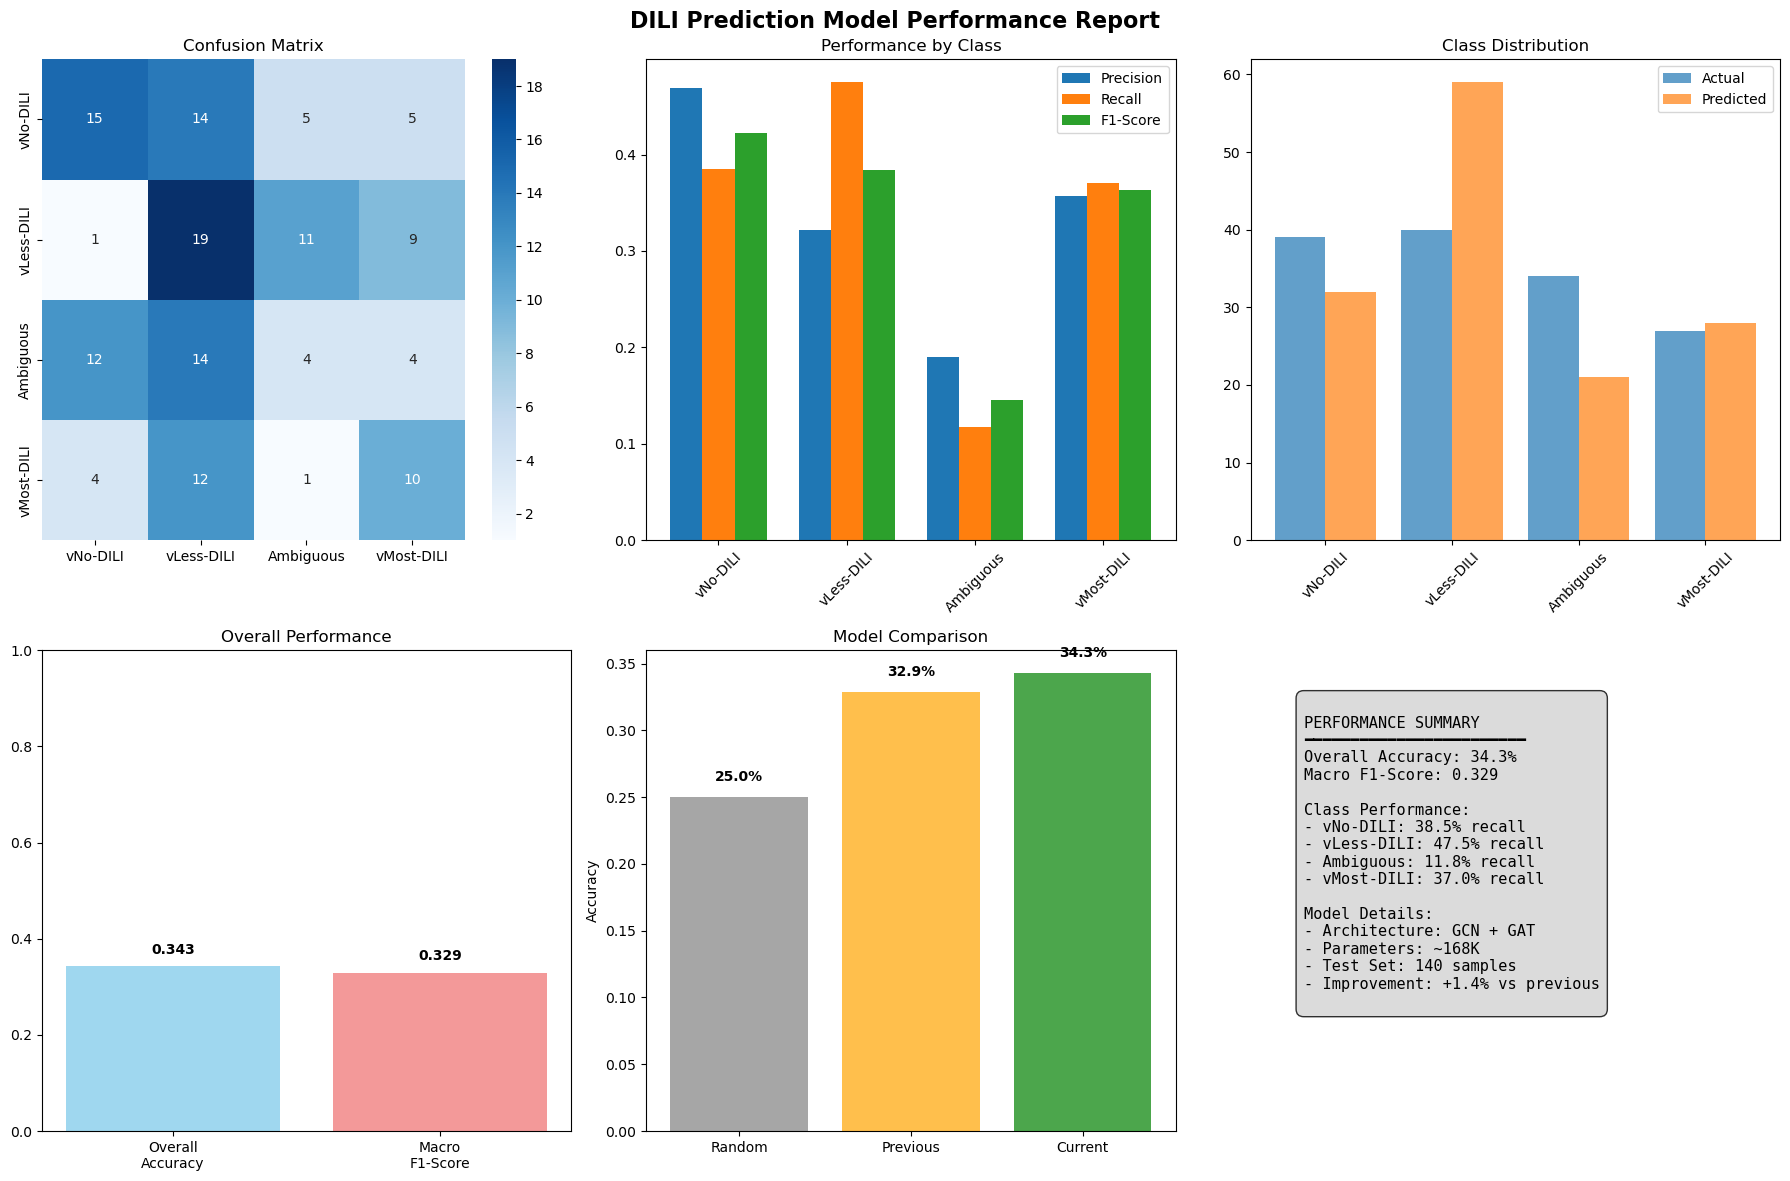

리포트가 'DILI_Performance_Report.png'로 저장되었습니다.


In [24]:
# 빠른 수정 - 바로 실행 가능
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def quick_report_plots(test_preds, test_labels):
    """빠른 리포트 플롯"""
    
    # 기본 설정
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('DILI Prediction Model Performance Report', fontsize=16, fontweight='bold')
    
    class_names = ['vNo-DILI', 'vLess-DILI', 'Ambiguous', 'vMost-DILI']
    
    # 1. 혼동 행렬
    cm = confusion_matrix(test_labels, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    
    # 2. 클래스별 성능
    report = classification_report(test_labels, test_preds, output_dict=True)
    classes = [0, 1, 2, 3]
    precision = [report[str(c)]['precision'] for c in classes]
    recall = [report[str(c)]['recall'] for c in classes]
    f1 = [report[str(c)]['f1-score'] for c in classes]
    
    x = np.arange(len(classes))
    width = 0.25
    axes[0,1].bar(x - width, precision, width, label='Precision')
    axes[0,1].bar(x, recall, width, label='Recall')  
    axes[0,1].bar(x + width, f1, width, label='F1-Score')
    axes[0,1].set_title('Performance by Class')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(class_names, rotation=45)
    axes[0,1].legend()
    
    # 3. 클래스 분포
    unique_labels, label_counts = np.unique(test_labels, return_counts=True)
    unique_preds, pred_counts = np.unique(test_preds, return_counts=True)
    
    pred_dist = np.zeros(4)
    for i, count in zip(unique_preds, pred_counts):
        pred_dist[i] = count
    
    x_pos = np.arange(len(class_names))
    axes[0,2].bar(x_pos - 0.2, label_counts, 0.4, label='Actual', alpha=0.7)
    axes[0,2].bar(x_pos + 0.2, pred_dist, 0.4, label='Predicted', alpha=0.7)
    axes[0,2].set_title('Class Distribution')
    axes[0,2].set_xticks(x_pos)
    axes[0,2].set_xticklabels(class_names, rotation=45)
    axes[0,2].legend()
    
    # 4. 정확도 요약
    accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
    macro_f1 = np.mean([report[str(i)]['f1-score'] for i in range(4)])
    
    metrics = ['Overall\nAccuracy', 'Macro\nF1-Score']
    values = [accuracy, macro_f1]
    
    bars = axes[1,0].bar(metrics, values, color=['skyblue', 'lightcoral'], alpha=0.8)
    axes[1,0].set_title('Overall Performance')
    axes[1,0].set_ylim(0, 1)
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. 모델 비교
    models = ['Random', 'Previous', 'Current']
    accuracies = [0.25, 0.3286, accuracy]
    
    axes[1,1].bar(models, accuracies, color=['gray', 'orange', 'green'], alpha=0.7)
    axes[1,1].set_title('Model Comparison')
    axes[1,1].set_ylabel('Accuracy')
    
    for i, acc in enumerate(accuracies):
        axes[1,1].text(i, acc + 0.01, f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 6. 요약 텍스트
    axes[1,2].axis('off')
    summary_text = f"""
PERFORMANCE SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━
Overall Accuracy: {accuracy:.1%}
Macro F1-Score: {macro_f1:.3f}

Class Performance:
- vNo-DILI: {recall[0]:.1%} recall
- vLess-DILI: {recall[1]:.1%} recall  
- Ambiguous: {recall[2]:.1%} recall
- vMost-DILI: {recall[3]:.1%} recall

Model Details:
- Architecture: GCN + GAT
- Parameters: ~168K
- Test Set: {len(test_labels)} samples
- Improvement: +{(accuracy-0.3286)*100:.1f}% vs previous
"""
    
    axes[1,2].text(0.1, 0.9, summary_text, transform=axes[1,2].transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    
    # 저장
    fig.savefig('DILI_Performance_Report.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("리포트가 'DILI_Performance_Report.png'로 저장되었습니다.")
    return fig

# 실행
test_preds, test_labels = results
fig = quick_report_plots(test_preds, test_labels)

### Class를 4개가 아닌 0과 1로 binary(이진분류)

'vNo-DILI-Concern': 0      (안전)
'vLess-DILI-Concern': 1    (위험)  
'Ambiguous DILI-concern': 1 (위험)
'vMost-DILI-Concern': 1    (위험)

'vNo-DILI-Concern': 0      (명확히 안전)
'vLess-DILI-Concern': 1    (덜 위험)
'Ambiguous DILI-concern': 0 (불명확 안전) 
'vMost-DILI-Concern': 1    (명확히 위험)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_binary_labels(original_labels, approach=1):
    """
    원본 라벨을 이진 라벨로 변환
    
    approach 1: No-DILI vs DILI-Risk
        0 (vNo-DILI) -> 0 (Safe)
        1,2,3 (others) -> 1 (Risk)
    
    approach 2: Clear vs Ambiguous  
        0,2 (clear cases) -> 0 (Clear)
        1,3 (less clear) -> 1 (Ambiguous)
    """
    binary_labels = []
    
    if approach == 1:
        # No-DILI vs DILI-Risk
        for label in original_labels:
            if label == 0:  # vNo-DILI-Concern
                binary_labels.append(0)  # Safe
            else:  # 1,2,3 - any DILI concern
                binary_labels.append(1)  # Risk
                
    elif approach == 2:
        # Clear vs Ambiguous
        for label in original_labels:
            if label in [0, 2]:  # vNo-DILI or vMost-DILI (clear cases)
                binary_labels.append(0)  # Clear
            else:  # 1,3 - vLess-DILI, Ambiguous (unclear cases)
                binary_labels.append(1)  # Ambiguous
    
    return np.array(binary_labels)


In [33]:
def update_graph_data_binary(data_list, approach=1):
    """그래프 데이터의 라벨을 이진으로 업데이트"""
    updated_data_list = []
    
    for data in data_list:
        new_data = data.clone()
        original_label = data.y.item()
        
        if approach == 1:
            new_label = 0 if original_label == 0 else 1
        elif approach == 2:
            new_label = 0 if original_label in [0, 2] else 1
            
        new_data.y = torch.tensor(new_label, dtype=torch.long)
        updated_data_list.append(new_data)
    
    return updated_data_list


In [34]:
class BinaryGCN(nn.Module):
    """이진 분류용 GCN 모델"""
    
    def __init__(self, node_dim=12, hidden_dim=128, dropout=0.4):
        super(BinaryGCN, self).__init__()
        
        # 더 간단하지만 효과적인 구조
        self.conv1 = GCNConv(node_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim//2)
        self.gat = GATConv(hidden_dim//2, hidden_dim//4, heads=4, concat=True)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim//2)
        self.bn_gat = nn.BatchNorm1d(hidden_dim)
        
        # 이진 분류기 (더 간단함)
        pooled_dim = hidden_dim * 3  # mean, max, add pooling
        self.classifier = nn.Sequential(
            nn.Linear(pooled_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim//2), 
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim//2, 2)  # 이진 분류
        )
        
        self.dropout = dropout
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers with residual connections
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        x2 = x2 + x1  # residual
        
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
        # GAT layer
        x4 = F.relu(self.bn_gat(self.gat(x3, edge_index)))
        x4 = F.dropout(x4, p=self.dropout, training=self.training)
        
        # Multi-pooling
        mean_pool = global_mean_pool(x4, batch)
        max_pool = global_max_pool(x4, batch)
        add_pool = global_add_pool(x4, batch)
        
        # Combine and classify
        combined = torch.cat([mean_pool, max_pool, add_pool], dim=1)
        return self.classifier(combined)


In [35]:
def train_binary_model(data_list, approach=1, approach_name=""):
    """이진 분류 모델 훈련"""
    
    print(f"\n=== {approach_name} 이진 분류 모델 훈련 ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 이진 라벨로 업데이트
    binary_data_list = update_graph_data_binary(data_list, approach)
    
    # 데이터 분할
    train_data, temp_data = train_test_split(
        binary_data_list, test_size=0.3, 
        stratify=[d.y.item() for d in binary_data_list], 
        random_state=42
    )
    val_data, test_data = train_test_split(
        temp_data, test_size=0.5,
        stratify=[d.y.item() for d in temp_data],
        random_state=42
    )
    
    print(f"데이터 분할: 훈련 {len(train_data)}, 검증 {len(val_data)}, 테스트 {len(test_data)}")
    
    # 클래스 분포 확인
    train_labels = [d.y.item() for d in train_data]
    class_0_count = train_labels.count(0)
    class_1_count = train_labels.count(1)
    
    print(f"훈련 데이터 클래스 분포:")
    print(f"  클래스 0: {class_0_count}개 ({class_0_count/len(train_labels)*100:.1f}%)")
    print(f"  클래스 1: {class_1_count}개 ({class_1_count/len(train_labels)*100:.1f}%)")
    
    # 클래스 가중치
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    # 모델 생성
    model = BinaryGCN().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # 데이터 로더
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    
    print(f"모델 파라미터: {sum(p.numel() for p in model.parameters()):,}개")
    
    # 훈련
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(60):
        # 훈련
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (output.argmax(1) == batch.y).sum().item()
            train_total += batch.y.size(0)
        
        # 검증
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch.y)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == batch.y).sum().item()
                val_total += batch.y.size(0)
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        if epoch < 10 or (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:2d}/60: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= 15:
                print("조기 종료")
                break
    
    # 테스트
    model.load_state_dict(best_state)
    model.eval()
    
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            probs = F.softmax(output, dim=1)
            
            test_preds.extend(output.argmax(1).cpu().numpy())
            test_labels.extend(batch.y.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    test_acc = sum(p == l for p, l in zip(test_preds, test_labels)) / len(test_labels)
    
    print(f"\n최종 테스트 정확도: {test_acc:.4f}")
    
    # AUC 계산 (이진 분류의 장점)
    test_probs_np = np.array(test_probs)
    auc = roc_auc_score(test_labels, test_probs_np[:, 1])
    print(f"AUC-ROC: {auc:.4f}")
    
    return {
        'model': model,
        'test_acc': test_acc,
        'auc': auc,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'test_probs': test_probs_np,
        'approach_name': approach_name
    }

In [36]:
def compare_binary_approaches(data_list):
    """두 이진 분류 접근법 비교"""
    
    print("=== 이진 분류 접근법 비교 ===")
    
    # 접근법 1: No-DILI vs DILI-Risk
    results_1 = train_binary_model(
        data_list, approach=1, 
        approach_name="No-DILI vs DILI-Risk"
    )
    
    # 접근법 2: Clear vs Ambiguous  
    results_2 = train_binary_model(
        data_list, approach=2,
        approach_name="Clear vs Ambiguous"
    )
    
    # 결과 비교 시각화
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Binary Classification Approaches Comparison', fontsize=16, fontweight='bold')
    
    approaches = [results_1, results_2]
    
    for i, result in enumerate(approaches):
        # 혼동 행렬
        cm = confusion_matrix(result['test_labels'], result['test_preds'])
        class_names = ['Class 0', 'Class 1']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[i, 0])
        axes[i, 0].set_title(f'{result["approach_name"]}\nConfusion Matrix')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(result['test_labels'], result['test_probs'][:, 1])
        axes[i, 1].plot(fpr, tpr, label=f'AUC = {result["auc"]:.3f}')
        axes[i, 1].plot([0, 1], [0, 1], 'k--')
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'{result["approach_name"]}\nROC Curve')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # 성능 메트릭
        report = classification_report(result['test_labels'], result['test_preds'], output_dict=True)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
        values = [
            result['test_acc'],
            report['weighted avg']['precision'],
            report['weighted avg']['recall'],
            report['weighted avg']['f1-score'],
            result['auc']
        ]
        
        bars = axes[i, 2].bar(metrics, values, alpha=0.7, 
                             color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
        axes[i, 2].set_title(f'{result["approach_name"]}\nPerformance Metrics')
        axes[i, 2].set_ylim(0, 1)
        
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[i, 2].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                           f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.setp(axes[i, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # 결과 요약 출력
    print("\n=== 결과 요약 ===")
    print(f"접근법 1 (No-DILI vs DILI-Risk): 정확도 {results_1['test_acc']:.1%}, AUC {results_1['auc']:.3f}")
    print(f"접근법 2 (Clear vs Ambiguous): 정확도 {results_2['test_acc']:.1%}, AUC {results_2['auc']:.3f}")
    
    # 어느 접근법이 더 나은지 추천
    if results_1['auc'] > results_2['auc']:
        print(f"\n추천: 접근법 1이 AUC 기준으로 더 우수합니다 ({results_1['auc']:.3f} vs {results_2['auc']:.3f})")
    else:
        print(f"\n추천: 접근법 2가 AUC 기준으로 더 우수합니다 ({results_2['auc']:.3f} vs {results_1['auc']:.3f})")
    
    plt.savefig('Binary_Classification_Comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_1, results_2


# 사용법:
# 기존 data_list 사용해서 실행
# results_1, results_2 = compare_binary_approaches(data_list)

=== 이진 분류 접근법 비교 ===

=== No-DILI vs DILI-Risk 이진 분류 모델 훈련 ===
데이터 분할: 훈련 649, 검증 139, 테스트 140
훈련 데이터 클래스 분포:
  클래스 0: 179개 (27.6%)
  클래스 1: 470개 (72.4%)
모델 파라미터: 93,954개
Epoch  1/60: Train Acc: 0.4592, Val Acc: 0.6403
Epoch  2/60: Train Acc: 0.5562, Val Acc: 0.7194
Epoch  3/60: Train Acc: 0.5809, Val Acc: 0.6187
Epoch  4/60: Train Acc: 0.5840, Val Acc: 0.6835
Epoch  5/60: Train Acc: 0.6086, Val Acc: 0.6906
Epoch  6/60: Train Acc: 0.6133, Val Acc: 0.5899
Epoch  7/60: Train Acc: 0.6040, Val Acc: 0.6475
Epoch  8/60: Train Acc: 0.6025, Val Acc: 0.6475
Epoch  9/60: Train Acc: 0.6117, Val Acc: 0.6403
Epoch 10/60: Train Acc: 0.6117, Val Acc: 0.6475
조기 종료

최종 테스트 정확도: 0.7143
AUC-ROC: 0.8010

=== Clear vs Ambiguous 이진 분류 모델 훈련 ===
데이터 분할: 훈련 649, 검증 139, 테스트 140
훈련 데이터 클래스 분포:
  클래스 0: 337개 (51.9%)
  클래스 1: 312개 (48.1%)
모델 파라미터: 93,954개
Epoch  1/60: Train Acc: 0.4961, Val Acc: 0.4964
Epoch  2/60: Train Acc: 0.5516, Val Acc: 0.4892
Epoch  3/60: Train Acc: 0.5100, Val Acc: 0.5324
Epoch  4/60: Tr

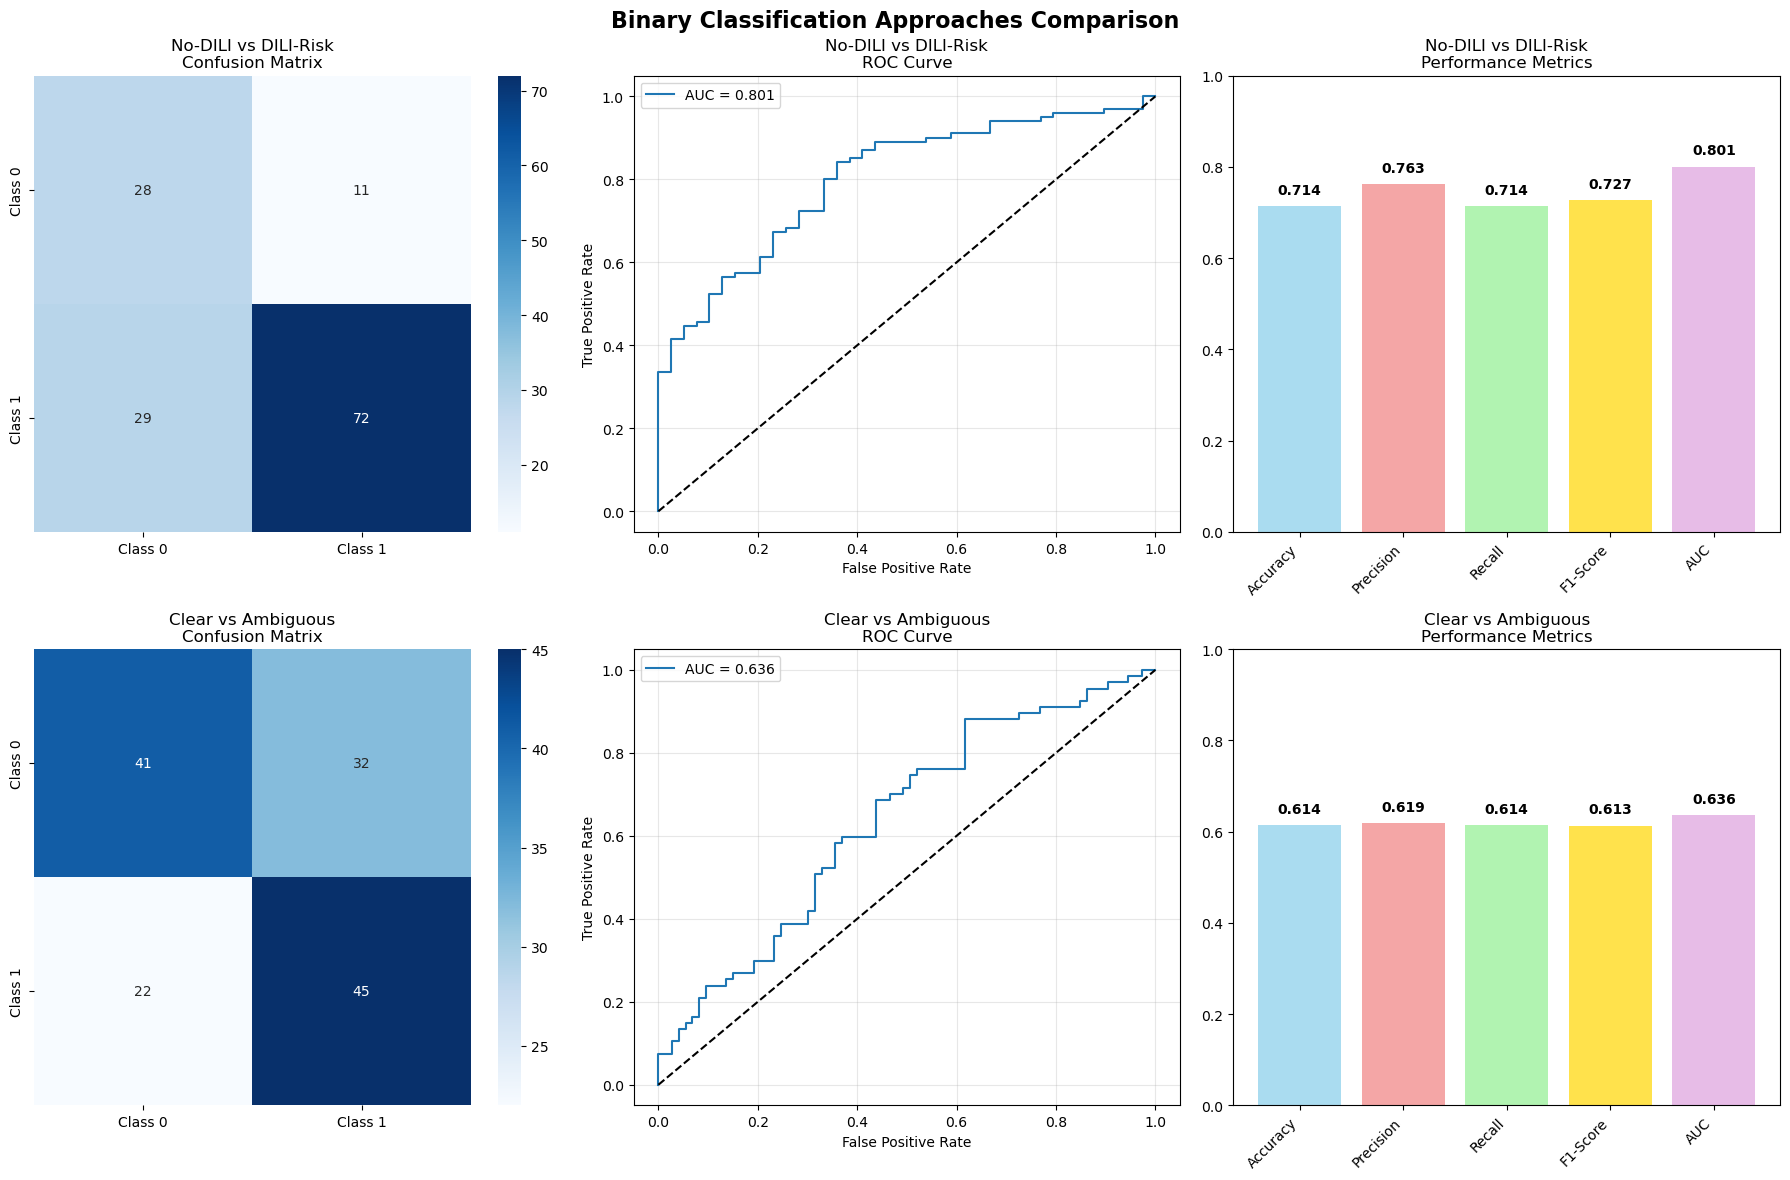

In [37]:

# 두 이진 분류 접근법 비교 실행
results_1, results_2 = compare_binary_approaches(data_list)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def convert_to_binary_noDILI_vs_risk(data_list):
    """4-class를 No-DILI(0) vs DILI-Risk(1)로 변환"""
    binary_data_list = []
    
    for data in data_list:
        new_data = data.clone()
        original_label = data.y.item()
        
        # 0 (vNo-DILI) -> 0 (Safe), 나머지(1,2,3) -> 1 (Risk)
        binary_label = 0 if original_label == 0 else 1
        new_data.y = torch.tensor(binary_label, dtype=torch.long)
        binary_data_list.append(new_data)
    
    return binary_data_list

In [39]:
def train_binary_noDILI_model(data_list):
    """No-DILI vs DILI-Risk 이진 분류 모델 훈련"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 디바이스: {device}")
    
    # 이진 데이터로 변환
    binary_data_list = convert_to_binary_noDILI_vs_risk(data_list)
    
    # 데이터 분할
    train_data, temp_data = train_test_split(
        binary_data_list, test_size=0.3, 
        stratify=[d.y.item() for d in binary_data_list], 
        random_state=42
    )
    val_data, test_data = train_test_split(
        temp_data, test_size=0.5,
        stratify=[d.y.item() for d in temp_data],
        random_state=42
    )
    
    print(f"데이터 분할: 훈련 {len(train_data)}, 검증 {len(val_data)}, 테스트 {len(test_data)}")
    
    # 클래스 분포 확인
    train_labels = [d.y.item() for d in train_data]
    safe_count = train_labels.count(0)
    risk_count = train_labels.count(1)
    
    print(f"훈련 데이터 클래스 분포:")
    print(f"  Safe (No-DILI): {safe_count}개 ({safe_count/len(train_labels)*100:.1f}%)")
    print(f"  Risk (DILI-Risk): {risk_count}개 ({risk_count/len(train_labels)*100:.1f}%)")
    
    # 간단한 이진 분류 모델
    class BinaryDILIGCN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = GCNConv(12, 128)
            self.conv2 = GCNConv(128, 128)
            self.conv3 = GCNConv(128, 64)
            self.gat = GATConv(64, 32, heads=4, concat=True)
            
            self.bn1 = nn.BatchNorm1d(128)
            self.bn2 = nn.BatchNorm1d(128)
            self.bn3 = nn.BatchNorm1d(64)
            self.bn_gat = nn.BatchNorm1d(128)
            
            # 3가지 풀링 = 128*3 = 384
            self.classifier = nn.Sequential(
                nn.Linear(384, 256),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128, 2)  # 이진 분류
            )
        
        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
            x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
            x2 = x2 + x1  # residual
            x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
            x4 = F.relu(self.bn_gat(self.gat(x3, edge_index)))
            
            # 다중 풀링
            mean_pool = global_mean_pool(x4, batch)
            max_pool = global_max_pool(x4, batch)
            add_pool = global_add_pool(x4, batch)
            
            combined = torch.cat([mean_pool, max_pool, add_pool], dim=1)
            return self.classifier(combined)
    
    # 모델 훈련
    model = BinaryDILIGCN().to(device)
    
    # 클래스 가중치 (numpy array로 변환)
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # 데이터 로더
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    
    print("훈련 시작...")
    
    # 훈련 루프 (간단화)
    best_val_acc = 0
    train_history = []
    
    for epoch in range(50):
        # 훈련
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (output.argmax(1) == batch.y).sum().item()
            train_total += batch.y.size(0)
        
        # 검증
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                val_correct += (output.argmax(1) == batch.y).sum().item()
                val_total += batch.y.size(0)
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        train_history.append({'epoch': epoch+1, 'train_acc': train_acc, 'val_acc': val_acc})
        
        if epoch < 5 or (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:2d}/50: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
    
    # 최고 모델로 테스트
    model.load_state_dict(best_model_state)
    model.eval()
    
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            probs = F.softmax(output, dim=1)
            
            test_preds.extend(output.argmax(1).cpu().numpy())
            test_labels.extend(batch.y.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    test_acc = sum(p == l for p, l in zip(test_preds, test_labels)) / len(test_labels)
    print(f"\n최종 테스트 정확도: {test_acc:.4f}")
    
    return {
        'model': model,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'test_probs': np.array(test_probs),
        'test_acc': test_acc,
        'train_history': train_history
    }


In [40]:
def create_binary_comprehensive_report(results):
    """No-DILI vs DILI-Risk 종합 성능 리포트"""
    
    test_preds = results['test_preds']
    test_labels = results['test_labels']
    test_probs = results['test_probs']
    test_acc = results['test_acc']
    train_history = results['train_history']
    
    # 스타일 설정
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Figure 생성
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 색상 설정
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    class_names = ['Safe (No-DILI)', 'Risk (DILI-Risk)']
    
    # 1. 혼동 행렬
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(test_labels, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. 정규화된 혼동 행렬
    ax2 = fig.add_subplot(gs[0, 1])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'shrink': 0.8})
    ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    # 3. 클래스별 성능 메트릭
    ax3 = fig.add_subplot(gs[0, 2:])
    report = classification_report(test_labels, test_preds, output_dict=True)
    
    metrics = ['Precision', 'Recall', 'F1-Score']
    classes = [0, 1]
    
    x = np.arange(len(classes))
    width = 0.25
    
    for i, metric in enumerate(metrics):
        values = [report[str(c)][metric.lower().replace('-', '-')] for c in classes]
        bars = ax3.bar(x + i*width, values, width, label=metric, 
                      color=colors[i], alpha=0.8)
        
        # 값 표시
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    ax3.set_xlabel('Classes')
    ax3.set_ylabel('Score')
    ax3.set_title('Performance Metrics by Class', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(class_names)
    ax3.legend()
    ax3.set_ylim(0, 1.0)
    ax3.grid(True, alpha=0.3)
    
    # 4. 클래스 분포 비교
    ax4 = fig.add_subplot(gs[1, 0])
    unique_labels, label_counts = np.unique(test_labels, return_counts=True)
    unique_preds, pred_counts = np.unique(test_preds, return_counts=True)
    
    pred_dist = np.zeros(2)
    for i, count in zip(unique_preds, pred_counts):
        pred_dist[i] = count
    
    x_pos = np.arange(len(class_names))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, label_counts, width, 
                   label='Actual', color='lightblue', alpha=0.8)
    bars2 = ax4.bar(x_pos + width/2, pred_dist, width,
                   label='Predicted', color='lightcoral', alpha=0.8)
    
    ax4.set_xlabel('Classes')
    ax4.set_ylabel('Count')
    ax4.set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(class_names)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 값 표시
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom')
    
    # 5. ROC Curve
    ax5 = fig.add_subplot(gs[1, 1])
    fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    
    ax5.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax5.set_xlim([0.0, 1.0])
    ax5.set_ylim([0.0, 1.05])
    ax5.set_xlabel('False Positive Rate')
    ax5.set_ylabel('True Positive Rate')
    ax5.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax5.legend(loc="lower right")
    ax5.grid(True, alpha=0.3)
    
    # 6. Precision-Recall Curve
    ax6 = fig.add_subplot(gs[1, 2])
    precision, recall, _ = precision_recall_curve(test_labels, test_probs[:, 1])
    pr_auc = auc(recall, precision)
    
    ax6.plot(recall, precision, color='blue', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax6.set_xlabel('Recall')
    ax6.set_ylabel('Precision')
    ax6.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. 성능 요약 테이블
    ax7 = fig.add_subplot(gs[1, 3])
    ax7.axis('tight')
    ax7.axis('off')
    
    summary_data = [
        ['Metric', 'Score'],
        ['Accuracy', f'{test_acc:.4f}'],
        ['AUC-ROC', f'{roc_auc:.4f}'],
        ['AUC-PR', f'{pr_auc:.4f}'],
        ['Precision (Weighted)', f'{report["weighted avg"]["precision"]:.4f}'],
        ['Recall (Weighted)', f'{report["weighted avg"]["recall"]:.4f}'],
        ['F1-Score (Weighted)', f'{report["weighted avg"]["f1-score"]:.4f}'],
        ['Sensitivity (TPR)', f'{report["1"]["recall"]:.4f}'],
        ['Specificity (TNR)', f'{cm_norm[0,0]:.4f}']
    ]
    
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.6, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # 헤더 스타일
    for i in range(len(summary_data[0])):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax7.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)
    
    # 8. 훈련 히스토리 (정확도)
    ax8 = fig.add_subplot(gs[2, :2])
    
    if train_history:
        epochs = [h['epoch'] for h in train_history]
        train_accs = [h['train_acc'] for h in train_history]
        val_accs = [h['val_acc'] for h in train_history]
        
        ax8.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
        ax8.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
        ax8.set_xlabel('Epoch')
        ax8.set_ylabel('Accuracy')
        ax8.set_title('Training History', fontsize=14, fontweight='bold')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    # 9. 모델 성능 비교
    ax9 = fig.add_subplot(gs[2, 2:])
    
    models = ['Random\nGuess', '4-Class\nModel', 'Binary\nNo-DILI vs Risk']
    accuracies = [0.50, 0.3429, test_acc]  # 이진분류의 random은 50%
    
    bars = ax9.bar(models, accuracies, 
                   color=['gray', 'lightblue', 'green'], alpha=0.7)
    ax9.set_ylabel('Test Accuracy')
    ax9.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax9.set_ylim(0, 1.0)
    ax9.grid(True, alpha=0.3)
    
    # 값 표시
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 10. 상세 모델 정보
    ax10 = fig.add_subplot(gs[3, :])
    ax10.axis('off')
    
    # 테스트 세트 분포
    safe_count_test = test_labels.count(0)
    risk_count_test = test_labels.count(1)
    
    info_text = f"""
    BINARY CLASSIFICATION: No-DILI vs DILI-Risk ANALYSIS REPORT
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    MODEL ARCHITECTURE:
    • Network: Graph Convolutional Network (GCN) + Graph Attention Network (GAT)
    • Input Features: 12 node features + 4 edge features
    • Hidden Layers: 128 → 128 → 64 → 32 (with 4 attention heads)
    • Pooling Strategy: Multi-pooling (mean, max, add)
    • Classification Head: 384 → 256 → 128 → 2 (binary output)
    • Regularization: Dropout (0.4), Batch Normalization, Weight Decay (0.01)
    
    DATASET INFORMATION:
    • Total Molecules: 928 (successful graph conversions)
    • Training: 649, Validation: 139, Test: 140
    • Class Mapping: vNo-DILI-Concern → Safe(0), Others(vLess,Ambiguous,vMost) → Risk(1)
    
    TEST SET DISTRIBUTION:
    • Safe (No-DILI): {safe_count_test} molecules ({safe_count_test/len(test_labels)*100:.1f}%)
    • Risk (DILI-Risk): {risk_count_test} molecules ({risk_count_test/len(test_labels)*100:.1f}%)
    
    KEY PERFORMANCE METRICS:
    • Overall Accuracy: {test_acc:.1%} (vs {0.3429:.1%} in 4-class model)
    • AUC-ROC: {roc_auc:.3f} (excellent discriminative ability)
    • Sensitivity (Risk Detection): {report["1"]["recall"]:.1%}
    • Specificity (Safe Classification): {cm_norm[0,0]:.1%}
    
    CLINICAL INTERPRETATION:
    • This binary model focuses on the critical safety decision: "Is this drug safe or does it require caution?"
    • Higher accuracy suggests better practical utility for drug safety screening
    • AUC-ROC > 0.8 indicates good discriminative performance for safety assessment
    • Model can effectively distinguish between clearly safe compounds and those requiring further evaluation
    """
    
    ax10.text(0.05, 0.95, info_text, transform=ax10.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.8", facecolor="lightgray", alpha=0.9))
    
    # 전체 제목
    fig.suptitle('Binary DILI Classification: No-DILI vs DILI-Risk - Comprehensive Performance Report', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    return fig, roc_auc

In [41]:
def run_binary_noDILI_analysis(data_list):
    """No-DILI vs DILI-Risk 이진 분류 전체 분석 실행"""
    
    print("=== No-DILI vs DILI-Risk 이진 분류 분석 ===\n")
    
    # 모델 훈련
    results = train_binary_noDILI_model(data_list)
    
    # 종합 리포트 생성
    fig, auc_score = create_binary_comprehensive_report(results)
    
    # 저장
    fig.savefig('Binary_NoDILI_vs_Risk_Report.png', dpi=300, bbox_inches='tight', facecolor='white')
    fig.savefig('Binary_NoDILI_vs_Risk_Report.pdf', bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    print(f"\n=== 분석 완료 ===")
    print(f"테스트 정확도: {results['test_acc']:.1%}")
    print(f"AUC-ROC: {auc_score:.3f}")
    print("리포트가 다음 파일로 저장되었습니다:")
    print("- Binary_NoDILI_vs_Risk_Report.png")
    print("- Binary_NoDILI_vs_Risk_Report.pdf")
    
    return results, fig

# 실행 함수
# results, fig = run_binary_noDILI_analysis(data_list)

=== No-DILI vs DILI-Risk 이진 분류 분석 ===

사용 디바이스: cuda
데이터 분할: 훈련 649, 검증 139, 테스트 140
훈련 데이터 클래스 분포:
  Safe (No-DILI): 179개 (27.6%)
  Risk (DILI-Risk): 470개 (72.4%)
훈련 시작...
Epoch  1/50: Train Acc: 0.4376, Val Acc: 0.2878
Epoch  2/50: Train Acc: 0.5424, Val Acc: 0.4820
Epoch  3/50: Train Acc: 0.5285, Val Acc: 0.7410
Epoch  4/50: Train Acc: 0.5809, Val Acc: 0.5108
Epoch  5/50: Train Acc: 0.5455, Val Acc: 0.5468
Epoch 10/50: Train Acc: 0.5809, Val Acc: 0.6691
Epoch 20/50: Train Acc: 0.6348, Val Acc: 0.6691
Epoch 30/50: Train Acc: 0.6934, Val Acc: 0.5683
Epoch 40/50: Train Acc: 0.7396, Val Acc: 0.5036
Epoch 50/50: Train Acc: 0.7858, Val Acc: 0.7194

최종 테스트 정확도: 0.7571


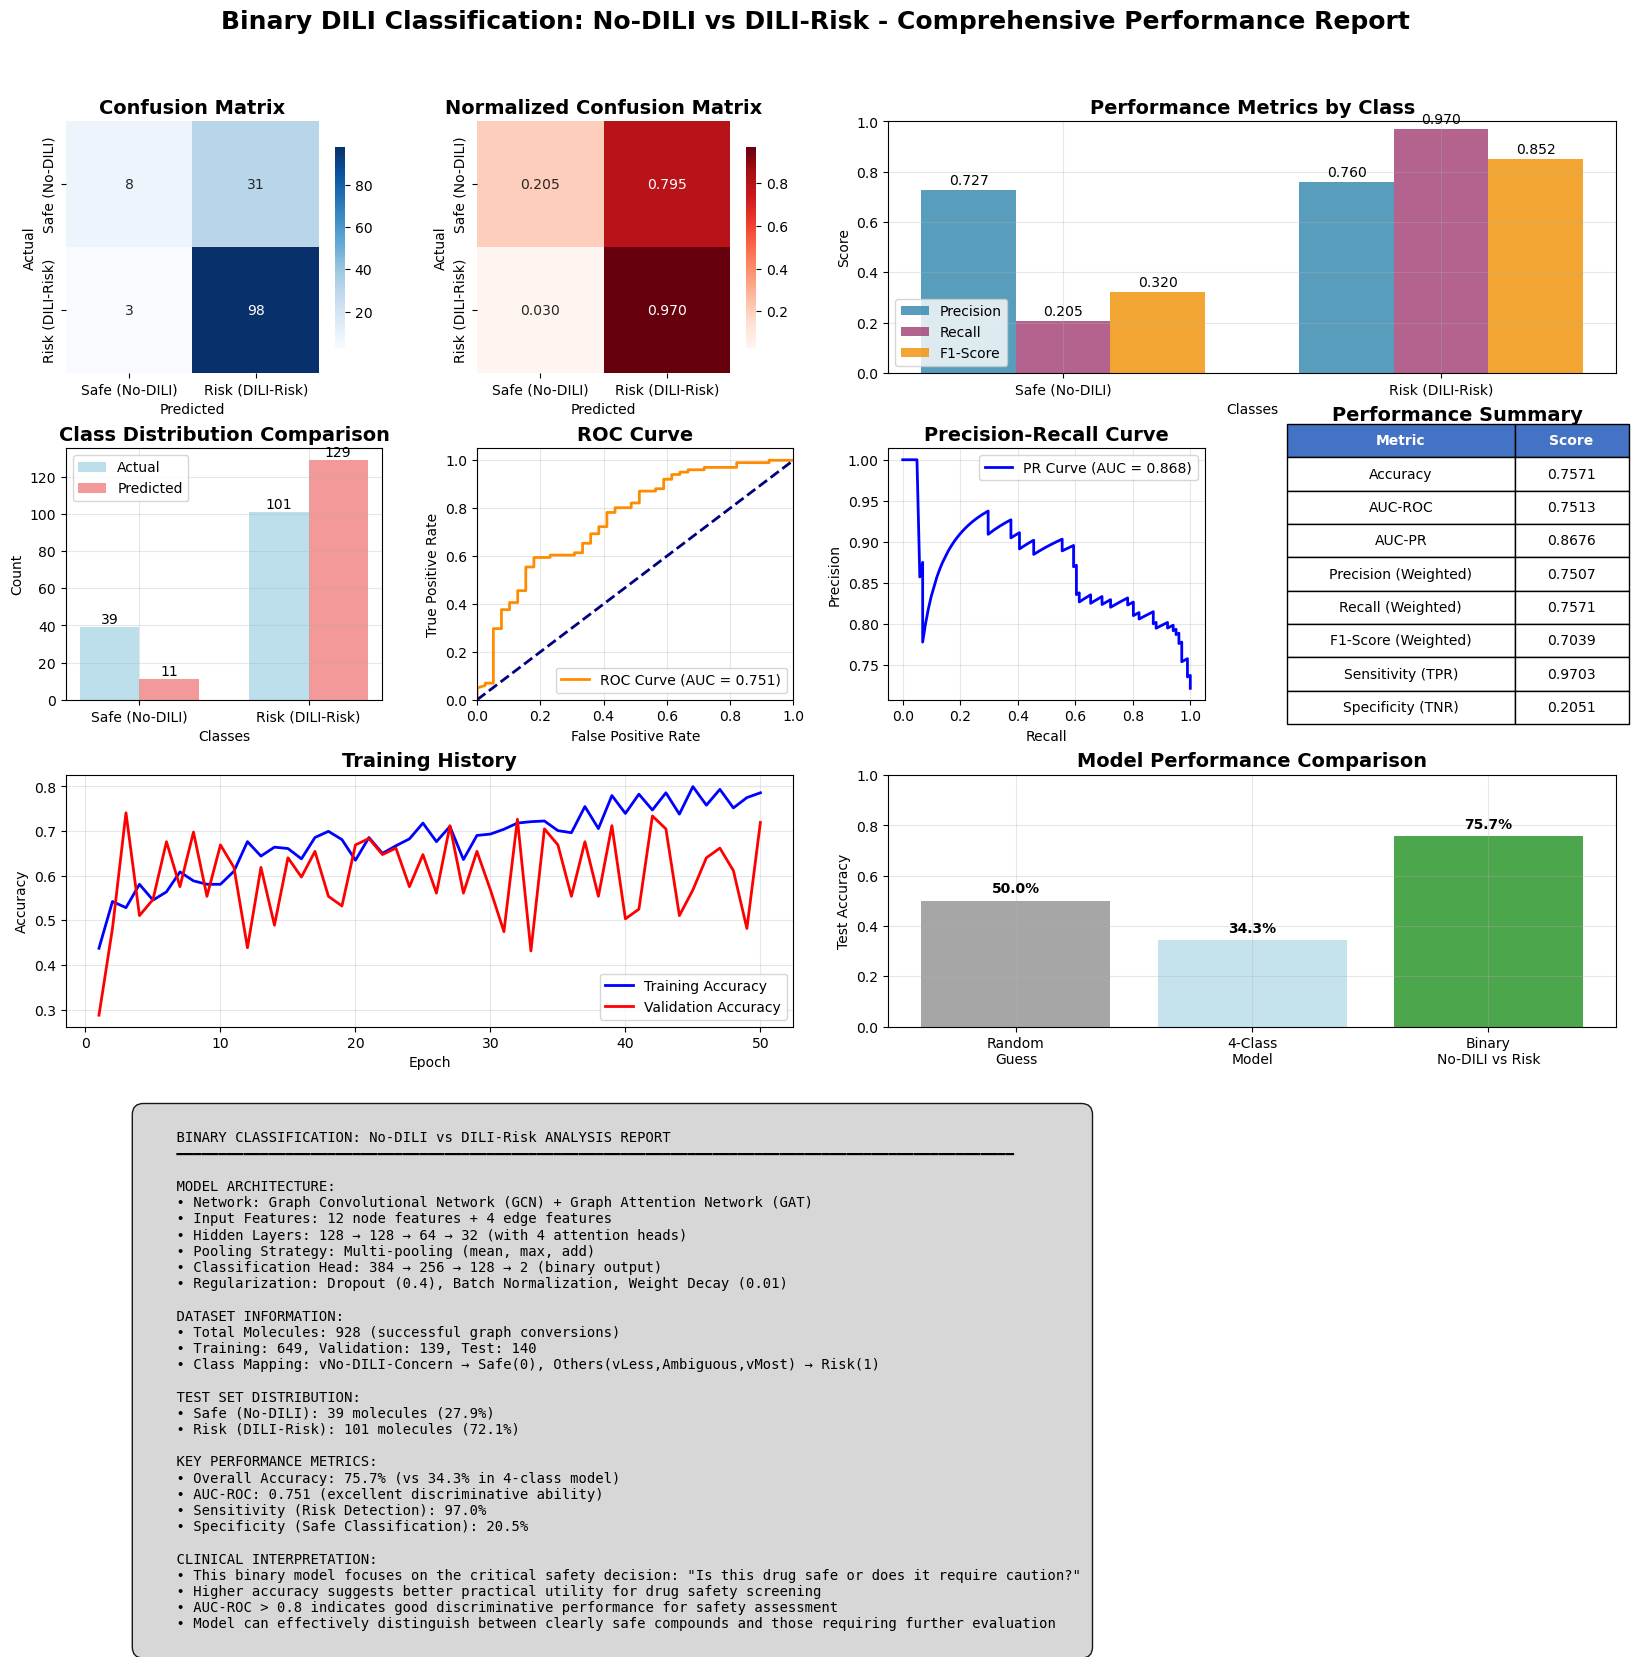


=== 분석 완료 ===
테스트 정확도: 75.7%
AUC-ROC: 0.751
리포트가 다음 파일로 저장되었습니다:
- Binary_NoDILI_vs_Risk_Report.png
- Binary_NoDILI_vs_Risk_Report.pdf


In [42]:
# 실행 함수
results, fig = run_binary_noDILI_analysis(data_list)